A [`Patch`](`dascore.core.patch.Patch`) is a section of contiguous, uniformly sampled data and metadata.

:::{.callout-note}
The `Patch` design was heavily inspired by
[Xarray's `DataArray` object](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)
:::

# Creating Patches

Patches can be generated in a few ways.

## Load an Example Patch

This example patch contains some artificially generated data. They are mostly used
for simple demonstrations or testing.


In [1]:
import dascore as dc

pa = dc.get_example_patch()

## Load a File

We first download a small example fiber file from a URL in the DASCore library (you need an internet connection).
Next, we simply read it into a [spool](spool.qmd) object then get the first (and only) patch.


In [2]:
import dascore as dc
from dascore.utils.downloader import fetch

path = fetch("terra15_das_1_trimmed.hdf5")  # path to a datafile

pa = dc.read(path)[0]
# or
pa = dc.spool(path)[0]

:::{.callout-note)
Both `dc.read` and `dc.spool` can be used to load data from a file.
`dc.read` will load the file contents into memory, whereas `dc.spool` will,
depending on the file support for scanning, often load data lazily.

Usually `dc.spool` is the function you want.
:::

## Create from Scratch

Patches can also be created from NumPy arrays and dictionaries. This requires:

- The data array
- The coordinates for labeling each axis
- The attributes (optional)


In [3]:
import numpy as np

import dascore as dc
from dascore.utils.time import to_timedelta64

# Create the patch data
array = np.random.random(size=(300, 2_000))

# Create attributes, or metadata
t1 = np.datetime64("2017-09-18")
attrs = dict(
    d_distance=1,
    d_time=to_timedelta64(1 / 250),
    category="DAS",
    id="test_data1",
    time_min=t1,
)

# Create coordinates, labels for each axis in the array.
coords = dict(
    distance=np.arange(array.shape[0]) * attrs["d_distance"],
    time=np.arange(array.shape[1]) * attrs["d_time"],
)

# define dimensions (first label corresponds to data axis 0)
dims = ('distance', 'time')

pa = dc.Patch(data=array, coords=coords, attrs=attrs, dims=dims)
print(pa)

<dascore.Patch (distance: 300, time: 2000)>
array([[0.9194943 , 0.23868682, 0.83094182, ..., 0.77098219, 0.14098217,
        0.48973159],
       [0.9284206 , 0.99734403, 0.25739683, ..., 0.65937549, 0.83956094,
        0.24109753],
       [0.29755791, 0.62667344, 0.94898858, ..., 0.44416282, 0.90828898,
        0.2997995 ],
       ...,
       [0.93229782, 0.31693225, 0.61505303, ..., 0.76666444, 0.06745831,
        0.71476074],
       [0.56240297, 0.14666931, 0.10520933, ..., 0.64233975, 0.69794441,
        0.28174161],
       [0.93886553, 0.4700688 , 0.89239454, ..., 0.336238  , 0.47057331,
        0.41713981]])
Coordinates:
  * distance  (distance) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * time      (time) datetime64[ns] 2017-09-18 ... 2017-09-18T00:00:07.996000
Attributes: (12/20)
    data_type:       
    data_category:   
    data_units:      
    time_min:        2017-09-18T00:00:00.000000000
    time_max:        2017-09-18T00:00:07.996000000
    d_time:          

# Attrs

The metadata stored in `Patch.attrs` is a
[pydnatic model](https://docs.pydantic.dev/usage/models/) which enforces some
basic schema validation. You can print the schema info like this:


In [4]:
import dascore as dc

print(dc.PatchAttrs.__doc__)


    The expected attributes for a Patch.

    Parameter
    ---------
    data_type
        The type of data collected (the meaning of the data). Valid values
        are ('', 'velocity', 'strain_rate', 'phase', 'strain', 'temperature', 'temperature_gradient').
    data_category
        The category of instrument which recorded the data. Valid values
        are ('', 'DAS', 'DTS', 'DSS').
    data_units
        The units in which the data are recorded (e.g., strain_rate).
    d_time
        The temporal sample spacing. If the patch is not evenly sampled
        this should be set to `np.timedelta64('NaT')`
    time_min
        The time represented by the first sample in the patch.
    time_max
        The time represented by the last sample in the patch.
    time_units
        The units of the time axis (in most cases should be seconds) or
        specified by datetime64 arrays in time coordinate.
    d_distance
        The spatial sampling rate, set to NaN if the patch is not evenly 

# Processing

For various reasons, Patches should be treated as *immutable*, meaning they should
not be modified in place, but rather new patches created when something needs to be
modified.

The patch has several methods which are intended to be chained together via a
[fluent interface](https://en.wikipedia.org/wiki/Fluent_interface), meaning each
method returns a new `Patch` instance.


In [5]:
import dascore as dc
pa = dc.get_example_patch()

out = (
    pa.decimate(time=8)  # decimate to reduce data volume by 8 along time dimension
    .detrend(dim='distance')  # detrend along distance dimension
    .pass_filter(time=(None, 10))  # apply a low-pass 10 Hz butterworth filter
)

The processing methods are located in the [dascore.proc](`dascore.proc`) package.

# Visualization

DASCore provides various visualization functions found in the [dascore.viz](`dascore.viz`)
package or using the `Patch.viz` namespace. DASCore generally only implements simple, matplotlib
based visualizations but other DASDAE packages will do more interesting visualizations.


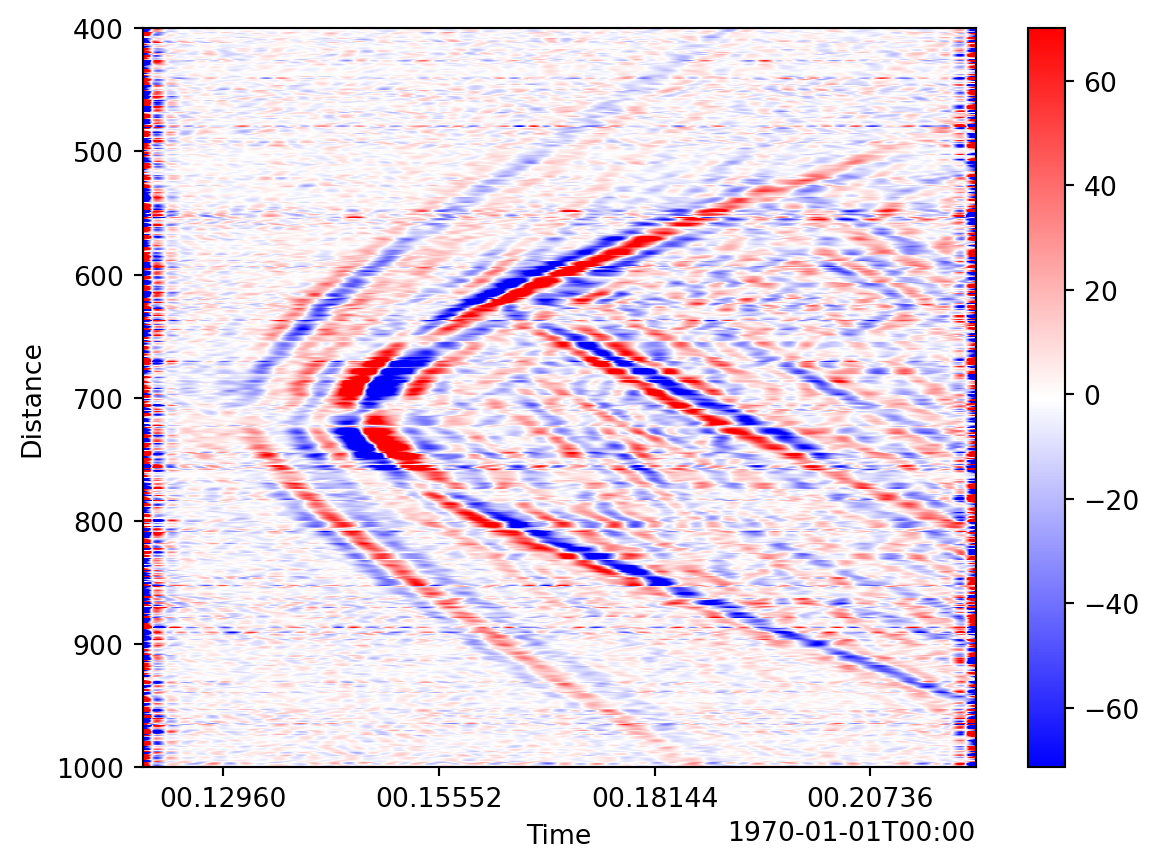

In [6]:
import dascore as dc
patch = (
    dc.get_example_patch('example_event_1')
    .pass_filter(time=(None, 300))
)

patch.viz.waterfall(show=True, scale=0.04);

# Modifying Patches

Because patches should be treated as immutable objects, you can't just modify
them with normal item assignment. There are a few methods that return new
patches with modifications, however, that are functionally the same.

## New

Often you may wish to modify one aspect of the patch. [`Patch.new`](`dascore.core.patch.Patch.new`)
is designed for this purpose:


In [7]:
import dascore as dc
pa = dc.get_example_patch()

# create a copy of patch with new data but coords and attrs stay the same
new = pa.new(data=pa.data * 10)

## Update Attrs

[`Patch.update_attrs`](`dascore.core.patch.Patch.update_attrs`) is for making small changes
to the patch attrs (metadata) while keeping the unaffected metadata (`Patch.new` would require
you replace the entirety of attrs).


In [8]:
import dascore as dc
pa = dc.get_example_patch()

# update existing attribute 'network' and create new attr 'new_attr'
pa1 = pa.update_attrs(**{'network': 'exp1', 'new_attr': 42})

`Patch.update_attrs` also tries to keep the patch attributes consistent.
For example, changing the start, end, or sampling of a dimension should
update the other attributes affected by the change.


In [9]:
import dascore as dc
pa = dc.get_example_patch()

# update start time should also shift endtime
pa1 = pa.update_attrs(time_min='2000-01-01')

print(pa.attrs['time_min'])
print(pa1.attrs['time_min'])

2017-09-18T00:00:00.000000000
2000-01-01T00:00:00.000000000


# Method Chaining

In most cases, you should use method chaining as part of a
[fluent interface](https://en.wikipedia.org/wiki/Fluent_interface) when working with patches.

For example:
```{.python}
import dascore as dc

pa = (
    dc.get_example_patch()  # load the patch
    .pass_filter(time=(1, 10)  # apply bandpass filter
    .detrend(dim='time')  # detrend along time dimension
)
```

Similar to Pandas, `Patch` has a [pipe method](`dascore.core.patch.Patch.pipe`) so non-patch methods
can still be used in a method chain.


```{.python}
import dascore as dc

def func(patch, arg1=1):
    """Example non-patch method"""
    return patch.update_attrs(arg1=1)

pa = (
    dc.get_example_patch()
    .pass_filter(time=(None, 10))
    .detrend('time', 'linear')
    .pipe(func, arg1=3)
)
```

# Adding Coordinates

It is common to have additional coordinates, such as latitude/longitude,
attached to a particular dimension (e.g., distance). There are two ways
to add coordinates to a patch:

## Assign Coordinates

The [assign_coordinates](`dascore.utils.coords.assign_coords`) method will
add the requested coordinates and return a new patch instance.


In [10]:
import numpy as np
import dascore as dc
pa = dc.get_example_patch()
coords = pa.coords
dist = coords['distance']
time = coords['time']

# Add a single coordinate associated with distance dimension
lat = np.arange(0, len(dist)) * .001 -109.857952
out_1 = pa.assign_coords(latitude=('distance', lat))

# Add multiple coordinates associated with distance dimension
lon = np.arange(0, len(dist)) *.001 + 41.544654
out_2 = pa.assign_coords(
    latitude=('distance', lat),
    longitude=('distance', lon),
)

# Add multi-dimensional coordinates
quality = np.ones_like(pa.data)
out_3 = pa.assign_coords(
    quality=(pa.dims, quality)
)

## Coords in Patch Initialization

Any number of coordinates can also be assigned when the patch is initiated. For
coordinates other than those of the patch dimensions, the associated dimensions
must be specified. For example:


In [11]:
import dascore as dc
import numpy as np

# create data for patch
rand = np.random.RandomState(13)
array = rand.random(size=(20, 100))
time1 = np.datetime64("2020-01-01")

# create patch attrs
attrs = dict(dx=1, d_time=1 / 250.0, category="DAS", id="test_data1")
time_deltas = dc.to_timedelta64(np.arange(array.shape[1]) * attrs["d_time"])

# create coordinate data
distance = np.arange(array.shape[0]) * attrs["dx"]
time = time1 + time_deltas
quality = np.ones_like(array)
latitude = np.arange(array.shape[0]) * .001 - 111.00

# create coord dict
coords = dict(
    distance=distance,
    time=time,
    latitude=("distance", latitude),  # Note distance is attached dimension
    quality=(("distance", "time"), quality),  # Two attached dimensions here
)

# Define dimensions of array and init Patch
dims = ("distance", "time")
out = dc.Patch(data=array, coords=coords, attrs=attrs, dims=dims)